<a href="https://colab.research.google.com/github/venkatchintha/project1/blob/master/Object_detection_using_Vgg16_Backend.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Mount drive to colab**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
%ls /content/drive/My\ Drive/Kaggle/nexet

annotations/  labels/                 Test_images/     trained_model/
classes.txt   Monk_Object_Detection/  train_boxes.csv  train_labels.csv
desktop.ini   nexet_2017_1/           train.csv        train.lst


**Download data from kaggle and unzip to google drive**,
Dataset link: https://www.kaggle.com/solesensei/nexet-original

In [ ]:
! pip install -q kaggle

In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/Kaggle"

In [ ]:
%cd /content/drive/My Drive/Kaggle

In [ ]:
!kaggle datasets download -d solesensei/nexet-original

In [ ]:
!unzip \*.zip  && rm *.zip

In [ ]:

print(os.listdir('/content/drive/My Drive/Kaggle'))

**Visualize data and convert data to monk format**

In [ ]:
import pandas as pd

df2 = pd.read_csv('/content/drive/My Drive/Kaggle/train_boxes.csv')
df2.head()

In [ ]:
import subprocess
import sys
import os, shutil
import pandas as pd
root= "/content/drive/My Drive/Kaggle/nexet/nexet/";
raw = []
archive = open("/content/drive/My Drive/Kaggle/nexet/nexet/train_boxes.csv","r")
raw = archive.readlines()
archive.close()

Dep = []
Acc = -1
temp = ""
temp2 = ""
processed = 0


for vals in raw :
    Acc = Acc + 1
    if Acc == 0:
        Dep.append("ID,Label")
    else :
        temp = vals
        match = temp.split(',')
        temp2 = ' '.join(match[1:len(match)-1])
        found = 0
        for k in range(0,len(Dep)):
            if match[0] in Dep[k] :
                found = k
        if found == 0 :       
            processed = processed + 1 
            Dep.append(match[0] +','+ temp2)
        else :
           Dep[processed] = Dep[processed] + ' ' + temp2

archive = open("/content/drive/My Drive/Kaggle/nexet/nexet/train_labels.csv","a")            
for l in Dep:
    archive.write(l)
    archive.write('\n')
    print (l)
    print( '\n')
archive.close()

In [ ]:
**Convert Monk to COCO format**



Monk Format
Dataset Directory Structure
/content/drive/My Drive/Kaggle/nexet/nexet/ (root)
      |
      |-----------Images (img_dir)
      |              |
      |              |------------------img1.jpg
      |              |------------------img2.jpg
      |              |------------------.........(and so on)
      |
      |
      |-----------train_labels.csv (anno_file)


Annotation file format
       | Id         | Labels`                                 `|
       | img1.jpg   | x1 y1 x2 y2 label1 x1 y1 x2 y2 label2  |

Labels: xmin ymin xmax ymax label
xmin, ymin - top left corner of bounding box
xmax, ymax - bottom right corner of bounding box

In [ ]:
COCO Format¶
Dataset Directory Structure
../sample_dataset (root_dir)
      |
      |------ship (coco_dir) 
      |         |
      |         |---Images (img_dir)
      |         |----|
      |              |-------------------img1.jpg
      |              |-------------------img2.jpg
      |              |-------------------.........(and so on)
      |
      |
      |         |---annotations (anno_dir)
      |         |----|
      |              |--------------------instances_Train.json 
      |              |--------------------classes.txt


instances_Train.json -> In proper COCO format
classes.txt -> A list of classes in alphabetical order

In [ ]:
import os
import numpy as np 
import cv2
import dicttoxml
import xml.etree.ElementTree as ET
from xml.dom.minidom import parseString
from tqdm import tqdm
import shutil
import json
import pandas as pd

In [ ]:

root= "/content/drive/My Drive/Kaggle/nexet/nexet";
img_dir = "nexet_2017_1/";
anno_file = "train_labels.csv";

In [ ]:
dataset_path = root;
images_folder = root + "/" + img_dir;
annotations_path = root + "/annotations/";

In [ ]:
if not os.path.isdir(annotations_path):
    os.mkdir(annotations_path)
    
input_images_folder = images_folder;
input_annotations_path = root + "/" + anno_file;

In [ ]:
output_dataset_path = root;
output_image_folder = input_images_folder;
output_annotation_folder = annotations_path;

tmp = img_dir.replace("/", "");
output_annotation_file = output_annotation_folder + "/instances_" + tmp + ".json";
output_classes_file = output_annotation_folder + "/classes.txt";

In [ ]:
if not os.path.isdir(output_annotation_folder):
    os.mkdir(output_annotation_folder);

In [ ]:
df = pd.read_csv(input_annotations_path);
columns = df.columns

In [ ]:
delimiter = " ";

In [ ]:

list_dict = [];
anno = [];
for i in range(len(df)):
    img_name = df[columns[0]][i];
    labels = df[columns[1]][i];
    tmp = labels.split(delimiter);
    for j in range(len(tmp)//5):
        label = tmp[j*5+4];
        if(label not in anno):
            anno.append(label);
    anno = sorted(anno)
    
for i in tqdm(range(len(anno))):
    tmp = {};
    tmp["supercategory"] = "master";
    tmp["id"] = i;
    tmp["name"] = anno[i];
    list_dict.append(tmp);

anno_f = open(output_classes_file, 'w');
for i in range(len(anno)):
    anno_f.write(anno[i] + "\n");
anno_f.close();

In [ ]:
coco_data = {};
coco_data["type"] = "instances";
coco_data["images"] = [];
coco_data["annotations"] = [];
coco_data["categories"] = list_dict;
image_id = 0;
annotation_id = 0;


for i in tqdm(range(len(df))):
    img_name = df[columns[0]][i];
    labels = df[columns[1]][i];
    tmp = labels.split(delimiter);
    image_in_path = input_images_folder + "/" + img_name;
    img = cv2.imread(image_in_path, 1);
    h, w, c = img.shape;

    images_tmp = {};
    images_tmp["file_name"] = img_name;
    images_tmp["height"] = h;
    images_tmp["width"] = w;
    images_tmp["id"] = image_id;
    coco_data["images"].append(images_tmp);
    

    for j in range(len(tmp)//5):
        x1 = int(float(tmp[j*5+0]));
        y1 = int(float(tmp[j*5+1]));
        x2 = int(float(tmp[j*5+2]));
        y2 = int(float(tmp[j*5+3]));
        label = tmp[j*5+4];
        annotations_tmp = {};
        annotations_tmp["id"] = annotation_id;
        annotation_id += 1;                                                                 
        annotations_tmp["image_id"] = image_id;
        annotations_tmp["segmentation"] = [];
        annotations_tmp["ignore"] = 0;
        annotations_tmp["area"] = (x2-x1)*(y2-y1);
        annotations_tmp["iscrowd"] = 0;
        annotations_tmp["bbox"] = [x1, y1, x2-x1, y2-y1];
        annotations_tmp["category_id"] = anno.index(label);

        coco_data["annotations"].append(annotations_tmp)
    image_id += 1;

outfile =  open(output_annotation_file, 'w');
json_str = json.dumps(coco_data, indent=4);
outfile.write(json_str);
outfile.close();

**Build model using Monk AI library**

In [3]:
! git clone https://github.com/Tessellate-Imaging/Monk_Object_Detection.git

Cloning into 'Monk_Object_Detection'...
remote: Enumerating objects: 7081, done.
remote: Total 7081 (delta 0), reused 0 (delta 0), pack-reused 7081
Receiving objects: 100% (7081/7081), 205.33 MiB | 36.10 MiB/s, done.
Resolving deltas: 100% (2818/2818), done.
Checking out files: 100% (6276/6276), done.


In [7]:
! cd Monk_Object_Detection/3_mxrcnn/installation && cat requirements_colab.txt | xargs -n 1 -L 1 pip install

     |████████████████████████████████| 540.1MB 18kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
  Created wheel for dicttoxml: filename=dicttoxml-1.7.4-cp36-none-any.whl size=17452 sha256=9d54619fb54b3999a329bda96bdbaf5309e0ee8e2707039f930d104b6e8486f3
  Stored in directory: /root/.cache/pip/wheels/62/4f/a3/afd4a68f5add45a668c14efa53b64d5cffb2be6bacf993c151
Successfully built dicttoxml


In [8]:
! pwd

/content


**Model Tarining**

In [53]:
import os
import sys
sys.path.append("Monk_Object_Detection/3_mxrcnn/lib/")
sys.path.append("Monk_Object_Detection/3_mxrcnn/lib/mx-rcnn")

In [54]:
from train_base import *

In [55]:
root_dir = "/content/drive/My Drive/Kaggle/";
coco_dir = "nexet";
img_dir = "nexet_2017_1";


In [56]:
set_dataset_params(root_dir=root_dir, 
                   coco_dir=coco_dir, imageset=img_dir);

In [57]:
set_model_params(model_name="vgg16");

In [58]:
set_hyper_params(gpus="0", lr=0.001, lr_decay_epoch="1", epochs=2, batch_size=1);

In [59]:
set_output_params(log_interval=100, save_prefix="model_vgg16");

In [60]:
set_img_preproc_params(img_short_side=600, img_long_side=1000, 
                       mean=(123.68, 116.779, 103.939), std=(1.0, 1.0, 1.0));

In [61]:
initialize_rpn_params();

In [62]:
initialize_rcnn_params();

In [63]:

if os.path.isdir("/content/drive/My Drive/Kaggle/nexet/cache/"):
    os.system("rm -r /content/drive/My Drive/Kaggle/nexet/cache/")

In [64]:
roidb = set_dataset();

INFO:root:loading cache /content/drive/My Drive/Kaggle/cache/coco_nexet_2017_1_roidb.pkl
INFO:root:coco_nexet_2017_1 num_images 49281
INFO:root:filter roidb: 49281 -> 49281
INFO:root:coco_nexet_2017_1 append flipped images to roidb


In [21]:
! pwd

/content


In [65]:
sym = set_network();

In [66]:
train(sym, roidb);

INFO:root:max input shape
{'bbox_target': (1, 36, 62, 62),
 'bbox_weight': (1, 36, 62, 62),
 'data': (1, 3, 1000, 1000),
 'gt_boxes': (1, 100, 5),
 'im_info': (1, 3),
 'label': (1, 1, 558, 62)}
INFO:root:max output shape
{'bbox_loss_reshape_output': (1, 128, 24),
 'blockgrad3_output': (1, 128),
 'cls_prob_reshape_output': (1, 128, 6),
 'rpn_bbox_loss_output': (1, 36, 62, 62),
 'rpn_cls_prob_output': (1, 2, 558, 62)}
INFO:root:locking params
['conv1_1_weight',
 'conv1_1_bias',
 'conv1_2_weight',
 'conv1_2_bias',
 'conv2_1_weight',
 'conv2_1_bias',
 'conv2_2_weight',
 'conv2_2_bias',
 'conv3_1_weight',
 'conv3_1_bias',
 'conv3_2_weight',
 'conv3_2_bias',
 'conv3_3_weight',
 'conv3_3_bias',
 'conv4_1_weight',
 'conv4_1_bias',
 'conv4_2_weight',
 'conv4_2_bias',
 'conv4_3_weight',
 'conv4_3_bias']
INFO:root:lr 0.001000 lr_epoch_diff [1] lr_iters [98562]
INFO:root:Epoch[0] Batch [0-100]	Speed: 1.43 samples/sec	RPNAcc=0.953705	RPNLogLoss=0.166176	RPNL1Loss=0.942712	RCNNAcc=0.890393	RCNNLogLo

In [78]:
!ls

download_vgg.sh  Monk_Object_Detection	sample_data
drive		 pretrained		trained_model


In [79]:
% cd trained_model

/content/trained_model


**Running inference**

In [80]:
!ls


model_vgg16-0001.params  model_vgg16-0002.params  model_vgg16-symbol.json


In [96]:
!pwd

/content/trained_model


In [105]:
import os
import sys
sys.path.append("Monk_Object_Detection/3_mxrcnn/lib/")
sys.path.append("Monk_Object_Detection/3_mxrcnn/lib/mx-rcnn")                                                                      

In [106]:
from infer_base import *

In [107]:
class_file = set_class_list("/content/drive/My Drive/Kaggle/nexet/annotations/classes.txt");

In [108]:
set_model_params(model_name="vgg16", model_path="/content/trained_model/model_vgg16-0002.params");

In [109]:
set_hyper_params(gpus="0", batch_size=1);

In [110]:
set_img_preproc_params(img_short_side=600, img_long_side=1000, 
                       mean=(123.68, 116.779, 103.939), std=(1.0, 1.0, 1.0));

In [111]:
initialize_rpn_params();

In [112]:

initialize_rcnn_params();

In [113]:
sym = set_network();
mod = load_model(sym);

In [122]:
!ls /content/drive/My Drive/Kaggle/nexet/Test_images

ls: cannot access '/content/drive/My': No such file or directory
ls: cannot access 'Drive/Kaggle/nexet/Test_images': No such file or directory


car
 0.47863301634788513 [3.66373046875, 289.4459375, 88.66251953125, 462.32125]
['car\n', 0.47863301634788513, [3.66373046875, 289.4459375, 88.66251953125, 462.32125]]


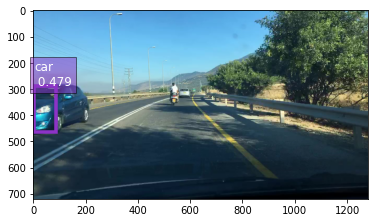

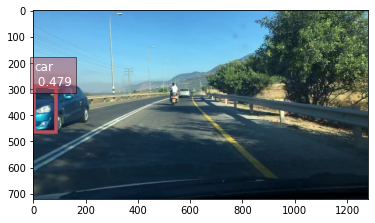

In [163]:

set_output_params(vis_thresh=0.2, vis=True)
Infer("/content/drive/My Drive/Kaggle/nexet/Test_images/7ee3a93b-7758-407a-bc33-2a7a158bbd4d.mov-0001.jpg", mod);

car
 0.8311370611190796 [772.32015625, 455.014765625, 1113.4021875, 703.83828125]
car
 0.6473657488822937 [439.6328515625, 417.9280078125, 599.0337109375, 608.8076953125]
car
 0.5389150977134705 [350.3873046875, 446.6435546875, 433.3419140625, 554.7635546875]
truck
 0.7308240532875061 [1.0254150390625, 400.56328125, 50.420771484375, 511.086640625]
truck
 0.6577863097190857 [277.29701171875, 428.938203125, 353.654296875, 520.443828125]
van
 0.4657232165336609 [449.638359375, 431.3559375, 596.613125, 602.820234375]
van
 0.3486521542072296 [360.74484375, 455.13234375, 449.8040625, 570.176953125]
['car\n', 0.8311370611190796, [772.32015625, 455.014765625, 1113.4021875, 703.83828125]]


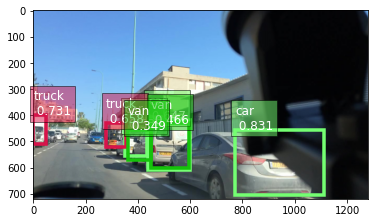

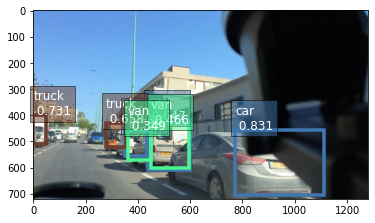

In [160]:
set_output_params(vis_thresh=0.3, vis=True)
Infer("/content/drive/My Drive/Kaggle/nexet/Test_images/e3c6ef8a-b411-467b-b441-690ed9e46c25.mov-0001.jpg", mod);

truck
 0.8057307600975037 [4.1012890625, 25.31140625, 388.1019140625, 517.6264453125]
['truck\n', 0.8057307600975037, [4.1012890625, 25.31140625, 388.1019140625, 517.6264453125]]


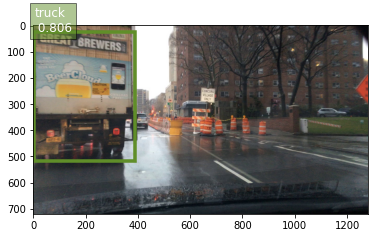

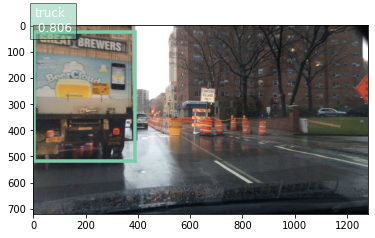

In [158]:
set_output_params(vis_thresh=0.8
                  , vis=True)
Infer("/content/drive/My Drive/Kaggle/nexet/Test_images/frame_721da0cf-febc-45c4-8610-bd993e0fa0b0_00001-1280_720.jpg", mod);